In [2]:
import numpy as np
import devito
from examples.seismic import AcquisitionGeometry
from examples.seismic import Receiver
from examples.seismic import TimeAxis
from examples.seismic import Model

# loading time_values, souce, src_coordinates and rec_cooridinates
geo = np.load('common.npy',allow_pickle = True).item()

# basic parameters
shape = (101, 51)                         # Number of grid points in x(horizonal) and y(vertical) direction.
spacing = (10., 10.)                      # Length of each grid in x and y direction (/m)
origin = (0, 0)                           # The coordinate of the left-top grid
nbl = 20                                  # Number of grids in damping layers
t0 = 0.                                   # Starting time
tn = 600.                                 # Stopping time
dt = 0.3                                  # Time step
f0 = 0.015                                # Maximum frequency parameter for Ricker wavelet(coinside with the given source)
nsources = 51                             # Number of sources
nreceivers = 204                          # Number of receivers

# Initial velocity field
v = np.empty(shape, dtype=np.float32)
v[:,:] = 1.5                              # initial wavespeed = 1.5km/s
model0 = Model(vp=v, origin=origin, shape=shape, spacing=spacing,space_order=4, nbl=nbl)

# Source coordinates and recevier coordinates
src_coordinates = geo['src_coordinates']          # Source coordinates
rec_coordinates = geo['rec_coordinates']          # Receiver coordinates

# Acquisition Geometry
geometry0 = AcquisitionGeometry(model0, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')

# Observation data
time_range = TimeAxis(start=t0, stop=tn, step=dt) # Time_range 
rec = Receiver(name='rec', grid=model0.grid, npoint=204, time_range=time_range)
rec.coordinates.data[:,0] = geo['rec_coordinates'][:,0]
rec.coordinates.data[:,1] = geo['rec_coordinates'][:,1]
d_obs = [];
for j in range(51):
    temp_data = np.load( 'project2_data_shot_' + str(j) + '.npy')
    rec.data[:,:204] = temp_data[:,:204]
    d_obs.append(rec)

ModuleNotFoundError: No module named 'examples'

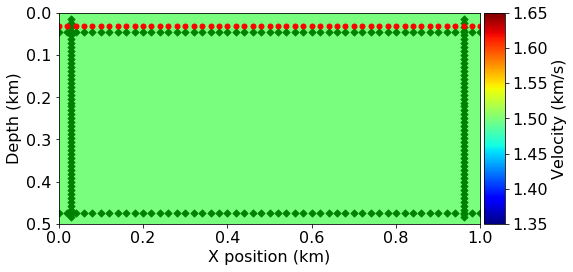

In [2]:
# Showing acquisition geometry
from examples.seismic import plot_velocity
plot_velocity(model0,source=src_coordinates,receiver=rec.coordinates.data)

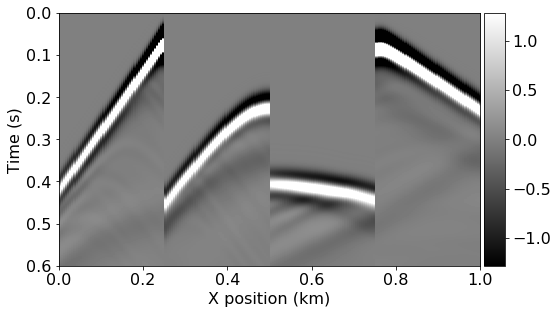

In [3]:
# Show receiving data of the last source
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord
plot_shotrecord(d_obs[50].data, model0, t0, tn)

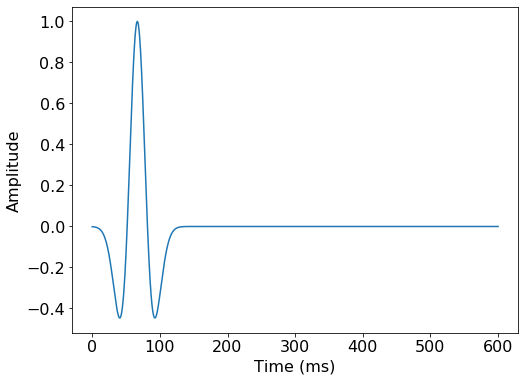

In [4]:
# Showing the source used
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource
src = RickerSource(name='src', grid=model0.grid, f0=f0, npoint=1, time_range=time_range)
src.show()

In [5]:
from examples.seismic.acoustic import AcousticWaveSolver
# Serial modeling function
def forward_modeling_single_shot(geometry, save=False, dt=0.3):
    solver = AcousticWaveSolver(geometry.model, geometry, space_order=4)
    d_obs, u0 = solver.forward(vp=geometry.model.vp, save=save)[0:2]
    return d_obs.resample(dt), u0

In [6]:
from devito import Function
from examples.seismic import Receiver
# Serial FWI objective function
def fwi_objective_single_shot(geometry, d_obs):
    # Devito objects for gradient and data residual
    grad = Function(name="grad", grid=geometry.model.grid)
    residual = Receiver(name='rec', grid=geometry.model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    solver = AcousticWaveSolver(geometry.model, geometry, space_order=4)
    # Predicted data and residual
    d_pred, u0 = solver.forward(vp=geometry.model.vp, save=True)[0:2]
    residual.data[:] = d_pred.data[:] - d_obs.resample(geometry.dt).data[:][0:d_pred.data.shape[0], :]
    # Function value and gradient    
    fval = .5*np.linalg.norm(residual.data.flatten())**2
    solver.gradient(rec=residual, u=u0, vp=geometry.model.vp, grad=grad)
    # Convert to numpy array and remove absorbing boundaries
    grad_crop = np.array(grad.data[:])[geometry.model.nbl:-geometry.model.nbl,
        geometry.model.nbl:-geometry.model.nbl]
    return fval, grad_crop

In [7]:
# Parallel FWI objective function
def fwi_objective_multi_shots(geometry, d_obs):
    futures = []
    for i in range(geometry.nsrc):
        # Geometry for current shot
        geometry_i = AcquisitionGeometry(geometry.model, geometry.rec_positions, geometry.src_positions[i, :], 
            geometry.t0, geometry.tn, f0=geometry.f0, src_type=geometry.src_type)
        # Call serial FWI objective function for each shot location
        futures.append(client.submit(fwi_objective_single_shot, geometry_i, d_obs[i]))
    # Wait for all workers to finish and collect function values and gradients
    wait(futures)
    fval = 0.0
    grad = np.zeros(geometry.model.shape)
    for i in range(geometry.nsrc):
        fval += futures[i].result()[0]
        grad += futures[i].result()[1]
    return fval, grad

In [8]:
from distributed import Client, LocalCluster, wait
# Start Dask cluster
cluster = LocalCluster(n_workers=nsources, death_timeout=600)
client = Client(cluster)
f, g = fwi_objective_multi_shots(geometry0, d_obs)

/home1/wangjianyu/anaconda3/envs/devito/lib/python3.7/site-packages/distributed/worker.py:3339: UserWarning: Large object of size 1.76 MB detected in task graph: 
  (<examples.seismic.utils.AcquisitionGeometry objec ... c(time, p_rec))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


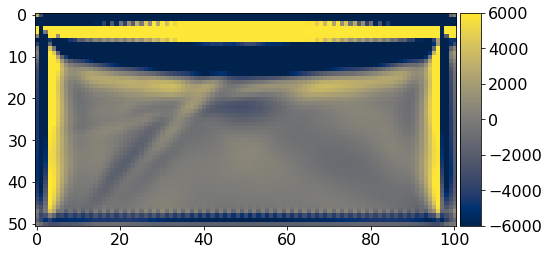

In [9]:
# Showing the gradient
from examples.seismic import plot_image
plot_image(g.reshape(model0.shape), vmin=-6e3, vmax=6e3, cmap="cividis")

In [10]:
# Wrapper for scipy optimizer: x is current model in squared slowness [s^2/km^2]
def loss(x, geometry, d_obs):
    # Convert x to velocity
    v_curr = 1.0/np.sqrt(x.reshape(geometry.model.shape))
    # Overwrite current velocity in geometry (don't update boundary region)
    geometry.model.vp.data[geometry.model.nbl:-geometry.model.nbl, geometry.model.nbl:-geometry.model.nbl] = v_curr
    # Evaluate objective function 
    fval, grad = fwi_objective_multi_shots(geometry, d_obs)
    return fval, grad.flatten().astype(np.float64)    # scipy expects double precision vector

In [11]:
# Box contraints
vmin = 0.5    # do not allow velocities slower than water
vmax = 10.0
bounds = [(1.0/vmax**2, 1.0/vmin**2) for _ in range(np.prod(model0.shape))]    # in [s^2/km^2]
# Initial guess
v0 = model0.vp.data[model0.nbl:-model0.nbl, model0.nbl:-model0.nbl]
m0 = 1.0 / (v0.reshape(-1).astype(np.float64))**2

In [12]:
from scipy import optimize
# FWI with L-BFGS
ftol = 0.1
maxiter = 5
result = optimize.minimize(loss, m0, args=(geometry0, d_obs), method='L-BFGS-B', jac=True, bounds=bounds, options={ 'maxiter':maxiter, 'disp':True})

In [13]:
# Check termination criteria
assert result['nit'] == maxiter

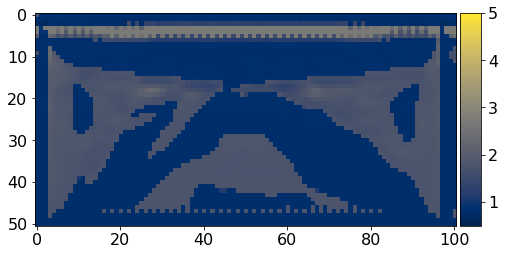

In [14]:
# Plot FWI result
vp = 1.0/np.sqrt(result['x'].reshape(model0.shape))
plot_image(vp, vmin=0.5, vmax=5.0, cmap="cividis")

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s


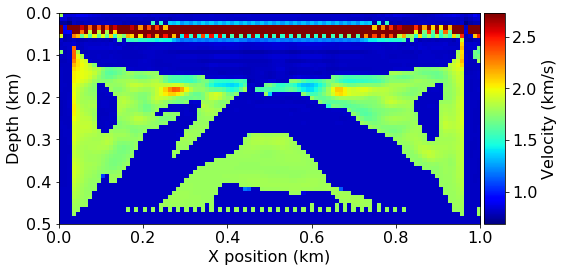

In [15]:
# Showing results
vp = 1.0/np.sqrt(result['x'].reshape(model0.shape))
model1 = Model(vp=vp, origin=origin, shape=shape, spacing=spacing,space_order=4, nbl=nbl,grid = model0.grid)
plot_velocity(model1)